In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

Import libraries

In [ ]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#Download Dataset


In [ ]:
!wget "https://us13.mailchimp.com/mctx/clicks?url=http%3A%2F%2Fdownload.cs.stanford.edu%2Fdeep%2FCheXpert-v1.0-small.zip&h=6716ecd6f0ca413b8b3e1ca21cb6436894b5dccb60ec1971f42d4b7a13fcfe15&v=1&xid=715bc99b0b&uid=55365305&pool=contact_facing&subject=CheXpert-v1.0%3A+Subscription+Confirmed" -O /content/datasets/chest_data.zip

--2022-09-09 08:28:18--  https://us13.mailchimp.com/mctx/clicks?url=http%3A%2F%2Fdownload.cs.stanford.edu%2Fdeep%2FCheXpert-v1.0-small.zip&h=6716ecd6f0ca413b8b3e1ca21cb6436894b5dccb60ec1971f42d4b7a13fcfe15&v=1&xid=715bc99b0b&uid=55365305&pool=contact_facing&subject=CheXpert-v1.0%3A+Subscription+Confirmed
Resolving us13.mailchimp.com (us13.mailchimp.com)... 104.89.119.59
Connecting to us13.mailchimp.com (us13.mailchimp.com)|104.89.119.59|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip [following]
--2022-09-09 08:28:19--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘/content/datasets/chest_data.zi

In [ ]:
%cd /content/datasets/
%ls
!unzip "chest_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: CheXpert-v1.0-small/train/patient21643/study3/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient21643/study3/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient21643/study1/
  inflating: CheXpert-v1.0-small/train/patient21643/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient21643/study2/
  inflating: CheXpert-v1.0-small/train/patient21643/study2/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient63218/
   creating: CheXpert-v1.0-small/train/patient63218/study1/
  inflating: CheXpert-v1.0-small/train/patient63218/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient08046/
   creating: CheXpert-v1.0-small/train/patient08046/study1/
  inflating: CheXpert-v1.0-small/train/patient08046/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient08046/study5/
  inflating: CheXpert-v1.0-small/train/patient08046/study5/view1_fron

# Read dataset

In [ ]:
data = pd.read_csv("/content/datasets/CheXpert-v1.0-small/train.csv")
data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
LABELS = data.columns[5:]
LABELS

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

# Split the dataset

For the data provided, we will split the dataset to 90% for training and 10% for validation

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=2019) #test size 10% overall

In [ ]:
train_data, val_data = train_test_split(train_data, test_size=0.22, random_state=2019) #validation size 20% overall

**To simplify the baseline model, the dataset is splited randomly. However, to improve the model, cross-validation techniques can be applied here**

# Build and train baseline model

In this notebook, we will use Pytorch library to implement and train ResNet50 as a baseline model. With initial weights from ImageNet, we will retrain all layers for this problem.

In [ ]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 64                              
LEARNING_RATE = 0.01
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100                              # Maximum number of training epochs

## Implement Dataset loader
In Pytorch, you need to subclass the `Dataset` of Pytorch to custom the data loading process. The **Image Augmentation** would be executed in this subclass

In [ ]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.Path)
            self.image_paths.append(image_path)
            if len(row) < 14:
                labels = [0] * 14
            else:
                labels = []
                for col in row[5:]:
                    if col == 1:
                        labels.append(1)
                    else:
                        labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

Create training dataset

In [ ]:
train_dataset = ChestXrayDataset("/content/datasets/", train_data, IMAGE_SIZE, True)

In [ ]:
val_dataset = ChestXrayDataset("/content/datasets/", val_data, IMAGE_SIZE, True)

Besides, `DataLoader` also need to be created. For the training data loader, we need to shuffle the dataset.

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

Let's check the size of data and label for each iteration

In [ ]:
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 14])


We also need to create validation dataloader. Different from training dataloader, we don't shuffle the validation set

In [ ]:
test_dataset = ChestXrayDataset("/content/drive/MyDrive/datasets/CheXpert-v1.0-small/train", test_data, IMAGE_SIZE, True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## Define model
In the baseline, we use DenseNet121 pretrained on ImageNet dataset. The classifier of model would be replaced with a new dense layer to make the output suit the problem.

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

## Check GPU available

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create model and get number of trainable parameters

In [ ]:
print(len(LABELS))

14


Create model and check model architecture

In [ ]:
model = DenseNet121(num_classes=len(LABELS)).to(device)
model

DenseNet121(
  (net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1

Number of trainable parameters

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6968206

We need to train about 7 millions parameters

## Define loss function, optimizer, and learning rate scheduler

In [ ]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

## Compute AUROC-score 
Because we have multi labels, we need to calculate AUROC-score for each class.

In [ ]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.cpu().numpy() 
    pred_np = y_pred.cpu().numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return auroc

## Training each epoch
This function will be called to train on one epoch


In [ ]:
# def epoch_training(epoch, model, train_dataloader,val_dataloader, device, loss_criteria, optimizer, mb):
# #def epoch_training(epoch, model, train_dataloader,val_dataloader device, loss_criteria, optimizer, mb):
  
# # Training with Validation

#     model.train()
#     training_loss = 0 # Storing sum of training losses
   
#     # For each batch
#     for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
#         # Move X, Y  to device (GPU)
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Clear previous gradient
#         optimizer.zero_grad()

#         # Feed forward the model
#         pred = model(images)
#         loss = loss_criteria(pred, labels)

#         # Back propagation
#         loss.backward()

#         # Update parameters
#         optimizer.step()

#         # Update training loss after each batch
#         training_loss += loss.item()

#         mb.child.comment = f'Training loss {training_loss/(batch+1)}'
     
#     del images, labels, loss
#     if torch.cuda.is_available(): torch.cuda.empty_cache()

#     # For each batch
#     for batch, (images, labels) in enumerate(progress_bar(val_dataloader, parent=mb)):
        
#         # Move X, Y  to device (GPU)
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Clear previous gradient
#         optimizer.zero_grad()

#         # Feed forward the model
#         valpred = model(images)
#         valloss = loss_criteria(valpred, labels)

#         # Update training loss after each batch
#         val_loss += valloss.item()

#         mb.child.comment = f'Validation loss {val_loss/(batch+1)}'
    
#     del images, labels, loss
#     if torch.cuda.is_available(): torch.cuda.empty_cache()

In [ ]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

## Evaluate model
This function is used to validate the model on the validation dataset

In [ ]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_auroc(out_gt, out_pred)).mean()

## Fully training
Fully training the model 

In [ ]:
import time

In [ ]:
!pip install fastprogress==0.1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


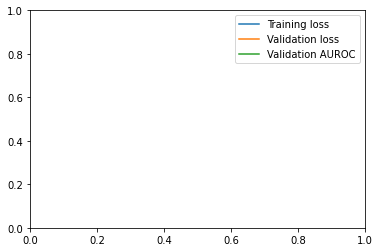

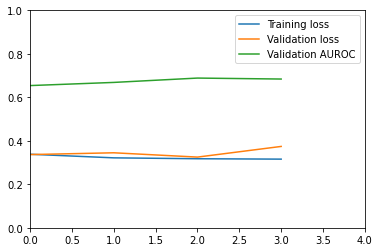

In [ ]:
# Best AUROC value during training
best_score = 0
model_path = "densenet.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
x = []

nonimproved_epoch = 0
start_time = time.time()

# Training each epoch
for epoch in mb:
    mb.main_bar.comment = f'Best AUROC score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(float(val_loss.cpu().detach().numpy()))
    validation_score.append(float(new_score))

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve AUROC from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        torch.save({"model": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), 
                    "best_score": best_score, 
                    "epoch": epoch, 
                    "lr_scheduler": lr_scheduler.state_dict()}, model_path)
    else: 
        nonimproved_epoch += 1
    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > 3600*8:
        break
        print("Out of time")

# Predict

In [ ]:
# test_df = pd.read_csv("../input/vietai-advanced-final-project-00/sample_submission.csv")
# test_df.head()

In [ ]:
# test_dataset = ChestXrayDataset("../input/vietai-advanced-final-project-00/test/test", test_df, IMAGE_SIZE, True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=700, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
state = torch.load(model_path, map_location=device)
model.load_state_dict(state["model"])
model.eval()

In [ ]:
from tqdm import tqdm

out_pred = torch.FloatTensor().to(device)
with torch.no_grad(): # Turn off gradient
    # For each batch
    correct=0
    for step, (images, labels) in tqdm(enumerate(test_dataloader)):
        # Move images, labels to device (GPU)
        images = images.to(device)
        labels=labels.to(device)

        # Feed forward the model
        ps = model(images)
        out_pred = torch.cat((out_pred, ps), dim=0)
        correct += (out_pred == labels).float().sum()


    accuracy = 100 * correct / len(test_dataloader)
    # trainset, not train_loader
    # probably x in your case

    print("Testing Accuracy = {}".format(accuracy))